Data Reading

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from tabulate import tabulate

# ====================================
# 📂 Step 2: Load Data
# ====================================
movies = pd.read_csv("../dataset/movie.csv")
ratings = pd.read_csv("../dataset/rating.csv")

# Display top rows
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Missing in movies: movieId    0
title      0
genres     0
dtype: int64
Missing in ratings: userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


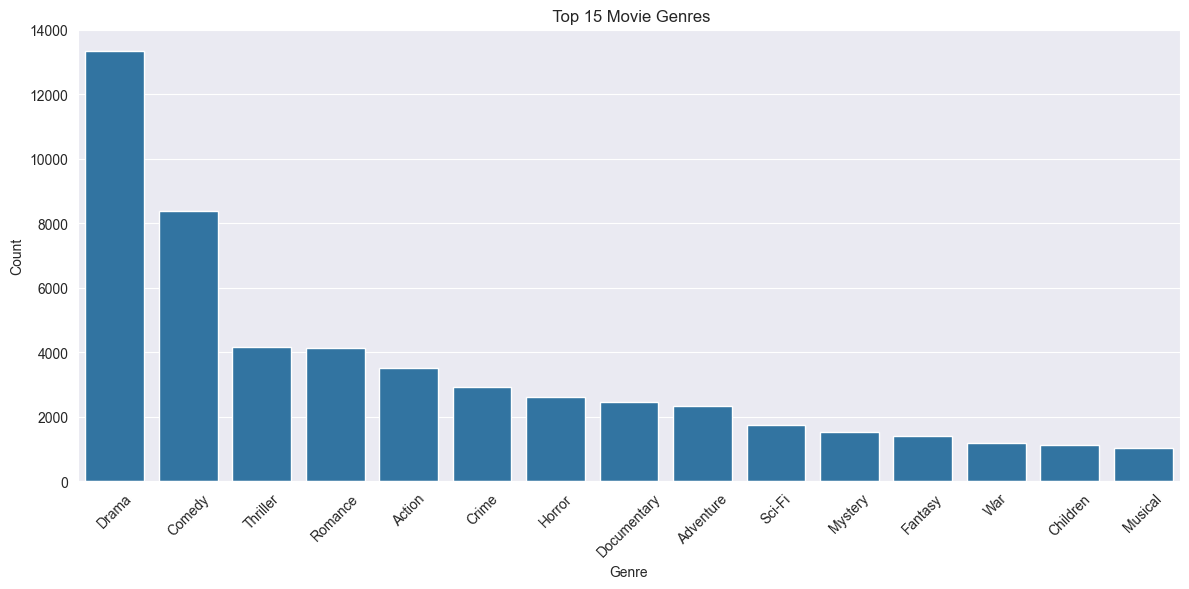

,movieId,title,genres,avg_rating
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3.921240
1,2,Jumanji (1995),Adventure Children Fantasy,3.211977
2,3,Grumpier Old Men (1995),Comedy Romance,3.151040
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2.861393
4,5,Father of the Bride Part II (1995),Comedy,3.064592


In [16]:
#====================================
# 🧹 Step 3: Preprocessing
# ====================================
# Handle missing values
print("Missing in movies:", movies.isnull().sum())
print("Missing in ratings:", ratings.isnull().sum())

# Drop duplicates
movies.drop_duplicates(inplace=True)

# Merge average ratings into movie dataset
avg_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
avg_ratings.columns = ['movieId', 'avg_rating']
movies = pd.merge(movies, avg_ratings, on='movieId', how='left')

# Fill missing genres with empty string
movies['genres'] = movies['genres'].fillna('')
# Replace "|" with spaces in genres
movies['genres'] = movies['genres'].str.replace('|', ' ', regex=False)


# Visual representation of top genres
genre_counts = movies['genres'].str.split().explode().value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=genre_counts.index[:15], y=genre_counts.values[:15])
plt.xticks(rotation=45)
plt.title(" Top 15 Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# cleaned dataset
movies.head()

In [17]:
# ====================================
# 📦 Step 4: Save Processed Data
# ====================================
movies.to_csv("processed_movies.csv", index=False)
print("✅ Saved processed data to processed_movies.csv")

✅ Saved processed data to processed_movies.csv


In [18]:
# ====================================
# 🧠 Step 5: TF-IDF on Genres (using saved data)
# ====================================
# Load the processed data
processed_movies = pd.read_csv("../notebook/processed_movies.csv")

tfidf = TfidfVectorizer()  # No need for custom `token_pattern
tfidf_matrix = tfidf.fit_transform(processed_movies['genres'])
# Show shape
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# Check feature names (genres)
print("\n📢 TF-IDF Feature Names (Genres):")
print(tfidf.get_feature_names_out()[:10])  # Show first 10 genres


TF-IDF matrix shape: (27278, 24)

📢 TF-IDF Feature Names (Genres):
['action' 'adventure' 'animation' 'children' 'comedy' 'crime'
 'documentary' 'drama' 'fantasy' 'fi']


In [19]:
# ====================================
# 🤖 Step 6: Train KNN Model
# ====================================
# Using cosine similarity
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(tfidf_matrix)

# Save model
with open("../model/knn_movie_model.pkl", "wb") as file:
    pickle.dump(knn_model, file)

# Save tfidf vectorizer
with open("../model/tfidf_vectorizer.pkl", "wb") as file:
    pickle.dump(tfidf, file)

print("Models saved successfully")


Models saved successfully


🔍 Testing Recommender System...


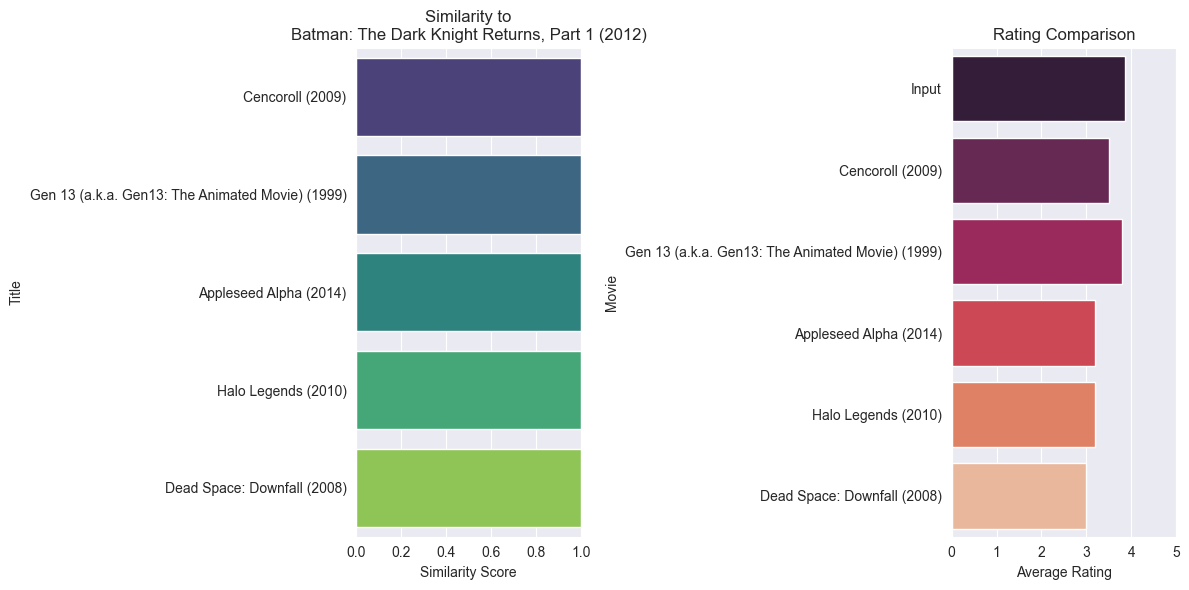


🎬 Input Movie: Batman: The Dark Knight Returns, Part 1 (2012)
📌 Genres: Action Animation Sci-Fi
⭐ Average Rating: 3.9

🌟 Top Recommendations:


,Title,Genres,Avg Rating,Similarity
0,Cencoroll (2009),Action Animation Sci-Fi,3.5,100.0%
1,Gen 13 (a.k.a. Gen13: The Animated Movie) (1999),Action Animation Sci-Fi,3.8,100.0%
2,Appleseed Alpha (2014),Action Animation Sci-Fi,3.2,100.0%
3,Halo Legends (2010),Action Animation Sci-Fi,3.2,100.0%
4,Dead Space: Downfall (2008),Action Animation Sci-Fi,3.0,100.0%


[{'Title': 'Cencoroll (2009)',
  'Genres': 'Action Animation Sci-Fi',
  'Avg Rating': '3.5',
  'Similarity': '100.0%'},
 {'Title': 'Gen 13 (a.k.a. Gen13: The Animated Movie) (1999)',
  'Genres': 'Action Animation Sci-Fi',
  'Avg Rating': '3.8',
  'Similarity': '100.0%'},
 {'Title': 'Appleseed Alpha (2014)',
  'Genres': 'Action Animation Sci-Fi',
  'Avg Rating': '3.2',
  'Similarity': '100.0%'},
 {'Title': 'Halo Legends (2010)',
  'Genres': 'Action Animation Sci-Fi',
  'Avg Rating': '3.2',
  'Similarity': '100.0%'},
 {'Title': 'Dead Space: Downfall (2008)',
  'Genres': 'Action Animation Sci-Fi',
  'Avg Rating': '3.0',
  'Similarity': '100.0%'}]

In [21]:
# ====================================
# 📈 Step 7: Test Pipeline with Saved Models (Fixed Warnings)
# ====================================
def test_recommendation_system(movie_title, n_recommendations=5):
    """Test the recommender using saved models with visualizations"""
    try:
        # 1. Load saved models
        with open("../model/knn_movie_model.pkl", "rb") as f:
            knn_loaded = pickle.load(f)

        with open("../model/tfidf_vectorizer.pkl", "rb") as f:
            tfidf_loaded = pickle.load(f)

        # 2. Prepare input data
        processed_movies = pd.read_csv("../notebook/processed_movies.csv")
        input_idx = processed_movies[processed_movies['title'].str.contains(movie_title, case=False)].index[0]
        input_movie = processed_movies.iloc[input_idx]

        # 3. Transform input and get recommendations
        input_tfidf = tfidf_loaded.transform([input_movie['genres']])
        distances, indices = knn_loaded.kneighbors(input_tfidf, n_neighbors=n_recommendations+1)

        # 4. Prepare results
        recommendations = []
        for i, dist in zip(indices[0][1:], distances[0][1:]):
            movie = processed_movies.iloc[i]
            recommendations.append({
                'Title': movie['title'],
                'Genres': movie['genres'],
                'Avg Rating': f"{movie['avg_rating']:.1f}",
                'Similarity': f"{1-dist:.1%}"
            })

        # 5. Visual Representation
        plt.figure(figsize=(12, 6))

        # Similarity Bar Plot (Fixed warning)
        plt.subplot(1, 2, 1)
        similarity_data = pd.DataFrame({
            'Title': [rec['Title'] for rec in recommendations],
            'Similarity': [1-d for d in distances[0][1:]]
        })
        sns.barplot(
            data=similarity_data,
            x='Similarity',
            y='Title',
            hue='Title',
            palette="viridis",
            legend=False
        )
        plt.title(f"Similarity to\n{input_movie['title']}")
        plt.xlabel("Similarity Score")
        plt.xlim(0, 1)

        # Ratings Comparison (Fixed warning)
        plt.subplot(1, 2, 2)
        ratings_data = pd.DataFrame({
            'Movie': ['Input'] + [rec['Title'] for rec in recommendations],
            'Rating': [float(input_movie['avg_rating'])] + [float(rec['Avg Rating']) for rec in recommendations]
        })
        sns.barplot(
            data=ratings_data,
            x='Rating',
            y='Movie',
            hue='Movie',
            palette="rocket",
            legend=False
        )
        plt.title("Rating Comparison")
        plt.xlabel("Average Rating")
        plt.xlim(0, 5)

        plt.tight_layout()
        plt.show()

        # 6. Tabular Output
        print(f"\n🎬 Input Movie: {input_movie['title']}")
        print(f"📌 Genres: {input_movie['genres']}")
        print(f"⭐ Average Rating: {input_movie['avg_rating']:.1f}\n")

        print("🌟 Top Recommendations:")
        display(pd.DataFrame(recommendations))

        return recommendations

    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None

# Test the system
print("🔍 Testing Recommender System...")
test_recommendation_system("The Dark Knight", n_recommendations=5)